# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
temp_prec = ['../Tabular_data/precipitation_all.csv', '../Tabular_data/temperature_all 2.csv']
static = None
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/variational_autoencoder_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, temp_prec=temp_prec, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)
The train shape is: (130, 1027)
The test shape is: (33, 1027)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.152315 -0.008257  0.229576 -0.459560 -0.115707 -0.250769   
      201547 -0.429644 -0.180829  0.196399  0.251703  0.151782  0.120646   
      201548 -0.161068  0.576082 -0.324825  0.105533  0.241237  0.022886   
      201549 -0.260170  0.167611 -0.298852  0.011480  0.048733  0.113631   
      201550  0.441330  0.225024  0.025560 -0.678361  0.065666 -0.795079   

                     6         7         8         9  ...      1017      1018  \
41001 201546 -0.473106 -0.372146 -0.407803  0.184894  ...  0.719872 -0.460573   
      201547 -0.128355 -0.304024  0.658483 -0.437008  ...  0.962856  0.200345   
      201548  0.055301 -0.310014 -0.244395  0.053250  ... -0.163233 -0.016585   
      201549 -0.398770 -0.094119  0.217093 -0.104882  ...  0.084838  0.005580   
      201550  0.085061 -0.637887  0.213285  0.176507  ...  0.399984 -0.400370   

                  1019      1020      1021      1022      1023  temperature  \
41001 201546 -0.098291 -0.444475  0.310875  0.028429  0.028352     0.109192   
      201547 -0.157422 -0.599799 -0.170341 -0.048648 -0.643602    -0.038879   
      201548  0.391008  0.751067  0.211474  0.279205 -0.449406     0.320644   
      201549  0.201473 -0.214119  0.614926 -0.373807  0.123735     0.490532   
      201550 -0.097594 -0.198839 -0.752909 -0.156427  0.308569     0.369630   

              precipitation    Labels  
41001 201546      -0.384028 -0.861740  
      201547      -0.701050 -0.854589  
      201548      -0.582182 -0.856973  
      201549      -0.884511 -0.856973  
      201550      -0.361735 -0.823600  

[5 rows x 1027 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.377501  0.058192 -0.121884  0.142221 -0.422123 -0.338568   
      201821  0.425911  0.212401 -0.038819 -0.400261  0.254694 -0.448073   
      201822 -0.069995  0.237755  0.151022 -0.046802  0.012595 -0.410129   
      201823  0.308861  0.156666  0.139823  0.301422 -0.530209 -0.318304   
      201824 -0.443093  0.134781 -0.274972  0.309000 -0.442412 -0.329776   

                     6         7         8         9  ...      1017      1018  \
41001 201820 -0.301512  0.143935  0.010483  0.500248  ...  0.280873 -0.205380   
      201821  0.297020 -0.398212  0.184892  0.256703  ... -0.105878 -0.163842   
      201822 -0.120283  0.390381 -0.328007  0.219778  ...  0.128836  0.114209   
      201823  0.175030  0.086659  0.598123  0.222864  ... -0.530318 -0.053215   
      201824 -0.570991 -0.178042  0.269263  0.467060  ...  0.198954  0.493463   

                  1019      1020      1021      1022      1023  temperature  \
41001 201820 -0.113414  0.261075  0.008019  0.469234 -0.946334    -0.094121   
      201821  0.379176 -0.059638  0.031588 -0.087280 -0.178241     0.023351   
      201822 -0.419445  0.404360  0.116429 -0.227992 -0.065731    -0.187106   
      201823 -0.268680 -0.174524 -0.212223  0.224780 -0.588565    -0.214029   
      201824  0.222790  0.380771 -0.155336 -0.109736  0.158721    -0.071286   

              precipitation    Labels  
41001 201820      -0.653238 -0.949940  
      201821      -0.600049 -0.961859  
      201822      -0.633564 -0.940405  
      201823      -0.884182 -0.961859  
      201824      -0.846962 -0.954708  

[5 rows x 1027 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 3079)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 3079)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 3078)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 3078)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 3078)
The test shape is (310, 3078)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 1026)
The test shape is (310, 3, 1026)


# 2. Model

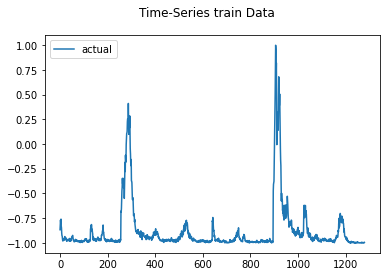

2023-03-10 22:55:30.828720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-10 22:55:30.828763: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 22:55:30.828787: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-10 22:55:30.829066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 22:55:33.168712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 30.843
Test RMSE: 42.460
Test sMAPE: 116.037
Test R Squared: -0.817
{'mae': 30.84263640949803, 'rmse': 42.45955640290296, 'smape': 116.03666442844654, 'r2': -0.8171293353430795}


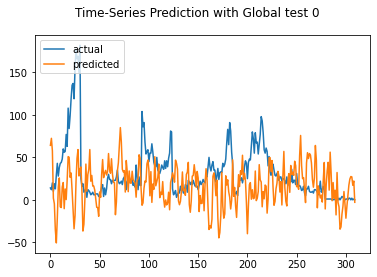

Test MAE: 39.747
Test RMSE: 48.374
Test sMAPE: 96.519
Test R Squared: -1.359
{'mae': 39.746613613059445, 'rmse': 48.37398231000582, 'smape': 96.51910165334397, 'r2': -1.358623478833981}


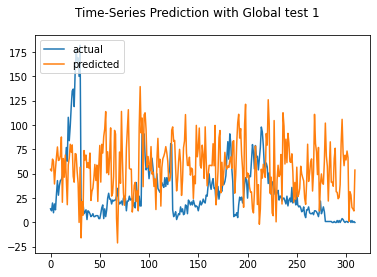

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 38.243
Test RMSE: 46.488
Test sMAPE: 98.040
Test R Squared: -1.178
{'mae': 38.242512372809074, 'rmse': 46.487587175540604, 'smape': 98.04020879912572, 'r2': -1.1782561357740984}


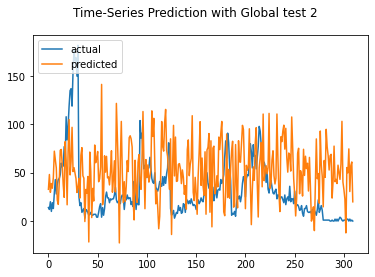

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 38.064
Test RMSE: 49.453
Test sMAPE: 97.754
Test R Squared: -1.465
{'mae': 38.0637266481115, 'rmse': 49.45266635599408, 'smape': 97.7541024695384, 'r2': -1.4649854471506023}


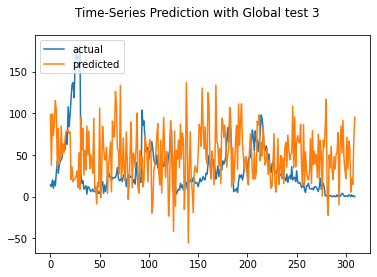

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.160
Test RMSE: 48.222
Test sMAPE: 114.125
Test R Squared: -1.344
{'mae': 37.16028849665196, 'rmse': 48.22174357654227, 'smape': 114.12452150223746, 'r2': -1.3438010966465836}


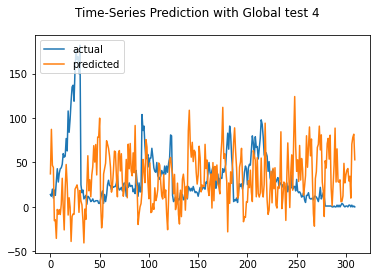

Test MAE: 41.188
Test RMSE: 47.288
Test sMAPE: 96.568
Test R Squared: -1.254
{'mae': 41.188466601217954, 'rmse': 47.28799756934642, 'smape': 96.56796939113399, 'r2': -1.2539111008229873}


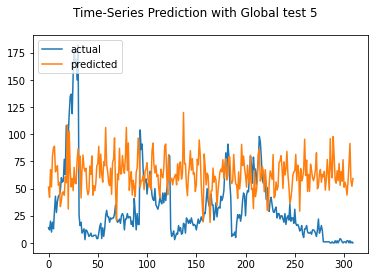

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 38.362
Test RMSE: 51.913
Test sMAPE: 124.332
Test R Squared: -1.716
{'mae': 38.36192267008366, 'rmse': 51.91296303887734, 'smape': 124.33240299557079, 'r2': -1.7163552687338863}


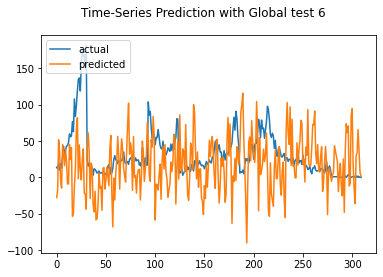

Test MAE: 52.056
Test RMSE: 74.877
Test sMAPE: 127.234
Test R Squared: -4.651
{'mae': 52.05571966978811, 'rmse': 74.87659774264934, 'smape': 127.23404130282762, 'r2': -4.651023843525261}


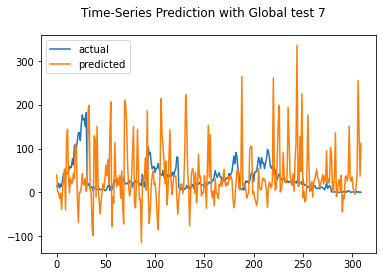

Test MAE: 70.332
Test RMSE: 80.746
Test sMAPE: 120.303
Test R Squared: -5.572
{'mae': 70.33157876306964, 'rmse': 80.74618713098435, 'smape': 120.30349456149241, 'r2': -5.571718956964258}


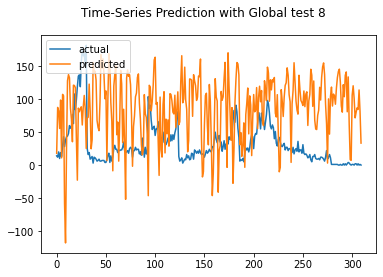

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 38.098
Test RMSE: 47.098
Test sMAPE: 94.965
Test R Squared: -1.236
{'mae': 38.098344027419245, 'rmse': 47.09781454481113, 'smape': 94.96473857422876, 'r2': -1.2358179834205236}


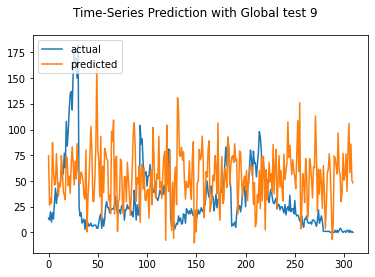

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 39.287
Test RMSE: 50.592
Test sMAPE: 103.480
Test R Squared: -1.580
{'mae': 39.28700957596302, 'rmse': 50.59230663418401, 'smape': 103.479878958536, 'r2': -1.5799060765457087}


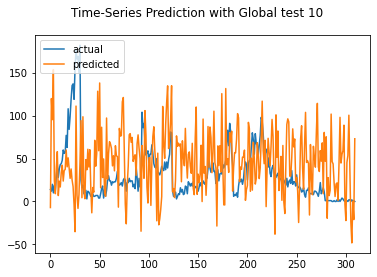

Test MAE: 43.808
Test RMSE: 49.604
Test sMAPE: 99.343
Test R Squared: -1.480
{'mae': 43.80822803743424, 'rmse': 49.60359394845647, 'smape': 99.34344813436392, 'r2': -1.4800544844140204}


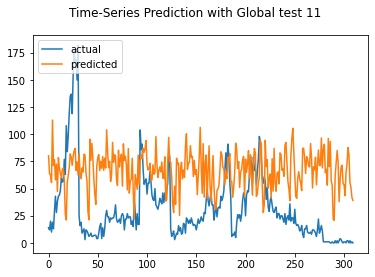

Test MAE: 49.150
Test RMSE: 61.901
Test sMAPE: 110.604
Test R Squared: -2.862
{'mae': 49.150195152721096, 'rmse': 61.90098414124736, 'smape': 110.60407181220872, 'r2': -2.862158047356672}


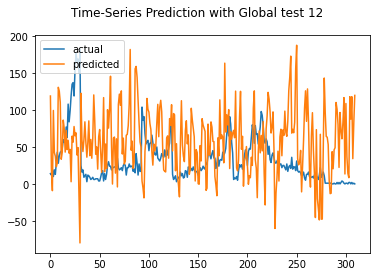

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 40.916
Test RMSE: 48.933
Test sMAPE: 97.205
Test R Squared: -1.413
{'mae': 40.91614211913078, 'rmse': 48.93300480971382, 'smape': 97.20492855285055, 'r2': -1.413452216634819}


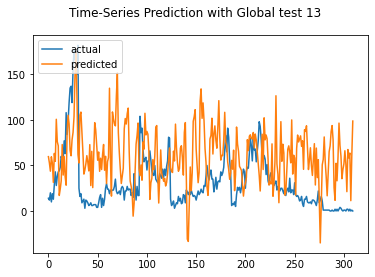

Test MAE: 64.503
Test RMSE: 75.494
Test sMAPE: 120.855
Test R Squared: -4.745
{'mae': 64.50319828371848, 'rmse': 75.49362568629866, 'smape': 120.85452922696643, 'r2': -4.7445432220518144}


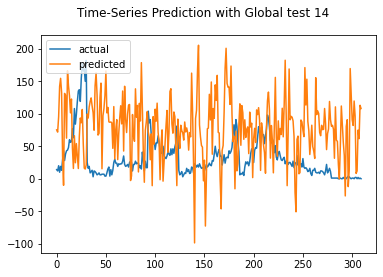

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 37.934
Test RMSE: 45.727
Test sMAPE: 93.323
Test R Squared: -1.108
{'mae': 37.93417307715262, 'rmse': 45.727039189394546, 'smape': 93.32344072885863, 'r2': -1.1075655848852333}


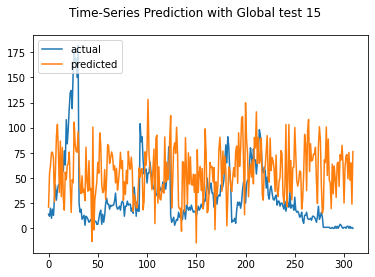

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 37.660
Test RMSE: 49.482
Test sMAPE: 107.322
Test R Squared: -1.468
{'mae': 37.66044604586017, 'rmse': 49.482003317585956, 'smape': 107.32195734680914, 'r2': -1.4679109368602679}


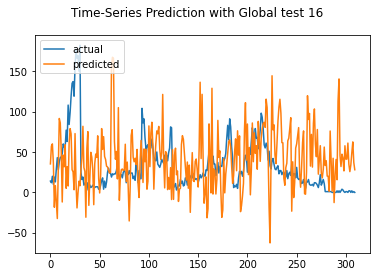

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 46.286
Test RMSE: 58.228
Test sMAPE: 105.091
Test R Squared: -2.417
{'mae': 46.28583765433681, 'rmse': 58.22796298893735, 'smape': 105.09059628685584, 'r2': -2.417418208281301}


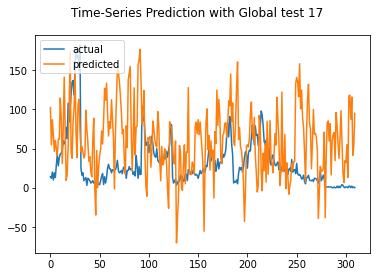

Test MAE: 32.823
Test RMSE: 40.320
Test sMAPE: 87.651
Test R Squared: -0.639
{'mae': 32.82252941131593, 'rmse': 40.319798695241865, 'smape': 87.65071403351915, 'r2': -0.6385950733758818}


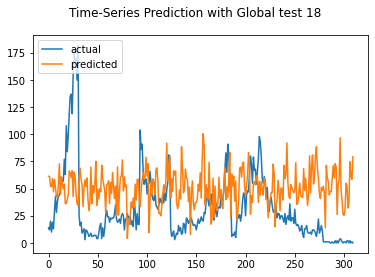

Test MAE: 43.184
Test RMSE: 49.368
Test sMAPE: 97.943
Test R Squared: -1.457
{'mae': 43.18367385095166, 'rmse': 49.36847420279001, 'smape': 97.94332853771303, 'r2': -1.4565994171210597}


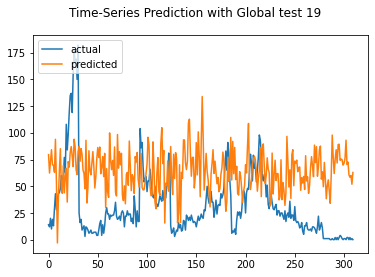

Test MAE: 39.351
Test RMSE: 46.369
Test sMAPE: 94.591
Test R Squared: -1.167
{'mae': 39.35052903698337, 'rmse': 46.368705382364226, 'smape': 94.59063167081516, 'r2': -1.1671295576541754}


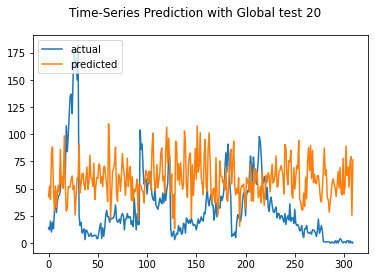

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 42.376
Test RMSE: 52.289
Test sMAPE: 98.926
Test R Squared: -1.756
{'mae': 42.37562257974378, 'rmse': 52.289074192125796, 'smape': 98.92570777190504, 'r2': -1.7558580211264139}


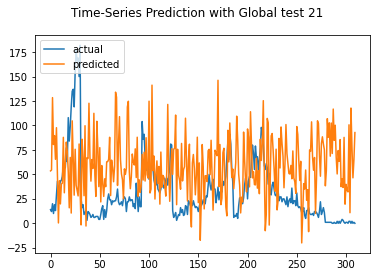

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 42.626
Test RMSE: 50.685
Test sMAPE: 98.063
Test R Squared: -1.589
{'mae': 42.62634659351841, 'rmse': 50.68510045425986, 'smape': 98.06335172481714, 'r2': -1.5893786190420314}


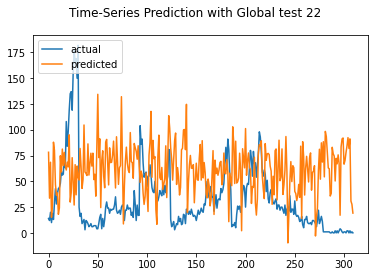

Test MAE: 43.191
Test RMSE: 50.843
Test sMAPE: 104.388
Test R Squared: -1.606
{'mae': 43.19121370084824, 'rmse': 50.84282844983288, 'smape': 104.38849835262432, 'r2': -1.6055195747492879}


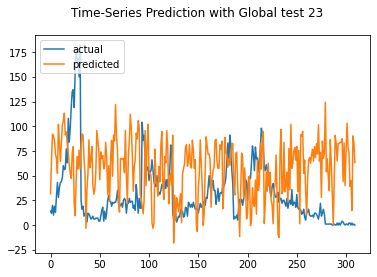

Test MAE: 38.906
Test RMSE: 44.376
Test sMAPE: 95.010
Test R Squared: -0.985
{'mae': 38.90608335925687, 'rmse': 44.375972485512996, 'smape': 95.00974537402388, 'r2': -0.9848637568043892}


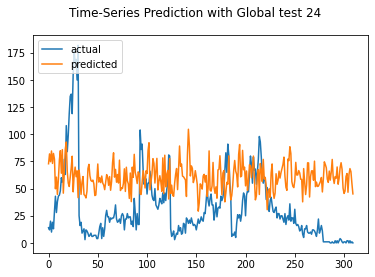

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 34.646
Test RMSE: 46.077
Test sMAPE: 124.146
Test R Squared: -1.140
{'mae': 34.645625809219574, 'rmse': 46.07664237233746, 'smape': 124.14574299634495, 'r2': -1.1399152962685717}


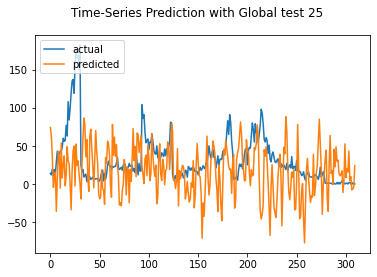

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 37.433
Test RMSE: 44.356
Test sMAPE: 95.226
Test R Squared: -0.983
{'mae': 37.433256168903846, 'rmse': 44.35573686509827, 'smape': 95.22599751196552, 'r2': -0.9830539579596584}


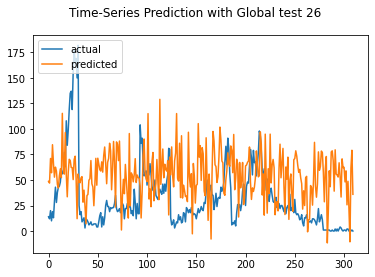

Test MAE: 37.291
Test RMSE: 43.581
Test sMAPE: 92.294
Test R Squared: -0.914
{'mae': 37.290689732951506, 'rmse': 43.5811769174996, 'smape': 92.29441807065709, 'r2': -0.9144006939281188}


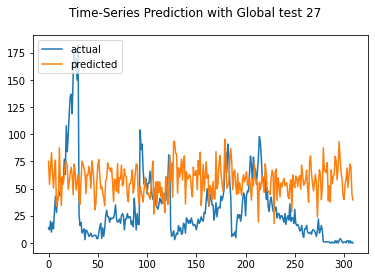

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 41.810
Test RMSE: 50.672
Test sMAPE: 98.287
Test R Squared: -1.588
{'mae': 41.80985420000169, 'rmse': 50.67239195555276, 'smape': 98.28706094041938, 'r2': -1.5880802891950192}


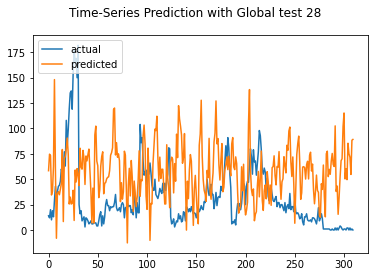

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 32.318
Test RMSE: 44.528
Test sMAPE: 121.848
Test R Squared: -0.998
{'mae': 32.31800855869247, 'rmse': 44.52773484401245, 'smape': 121.84826990629315, 'r2': -0.9984631294183572}


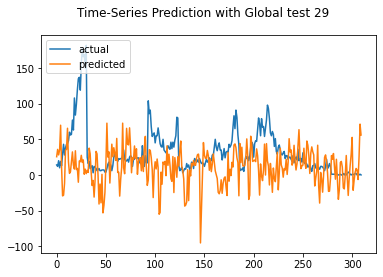

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 37.602
Test RMSE: 46.013
Test sMAPE: 93.001
Test R Squared: -1.134
{'mae': 37.60165924103029, 'rmse': 46.012813724580006, 'smape': 93.00112019983823, 'r2': -1.1339906764610612}


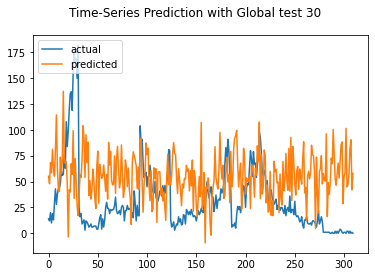

Test MAE: 40.965
Test RMSE: 50.517
Test sMAPE: 99.304
Test R Squared: -1.572
{'mae': 40.96477047128062, 'rmse': 50.517243120147654, 'smape': 99.30393189943473, 'r2': -1.5722561722376445}


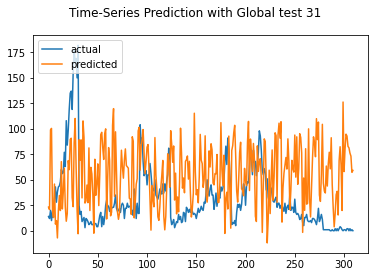

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 35.911
Test RMSE: 44.223
Test sMAPE: 90.136
Test R Squared: -0.971
{'mae': 35.9110228411613, 'rmse': 44.22253453957833, 'smape': 90.13635003386914, 'r2': -0.9711614365382555}


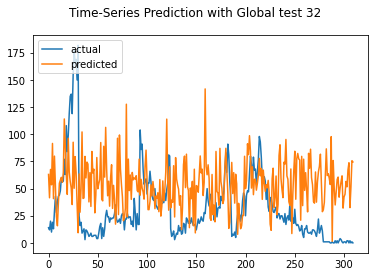

Test MAE: 36.678
Test RMSE: 42.375
Test sMAPE: 93.590
Test R Squared: -0.810
{'mae': 36.677668036184, 'rmse': 42.37473976171188, 'smape': 93.59037107988813, 'r2': -0.8098768398838612}


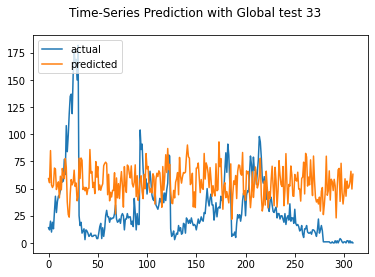

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.171
Test RMSE: 41.740
Test sMAPE: 113.249
Test R Squared: -0.756
{'mae': 31.171055925949926, 'rmse': 41.74014766446273, 'smape': 113.24892807503497, 'r2': -0.7560743391700355}


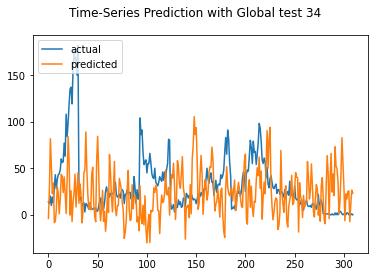

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 39.950
Test RMSE: 51.073
Test sMAPE: 120.516
Test R Squared: -1.629
{'mae': 39.949635602581886, 'rmse': 51.07332872351781, 'smape': 120.51628239482007, 'r2': -1.629197814834506}


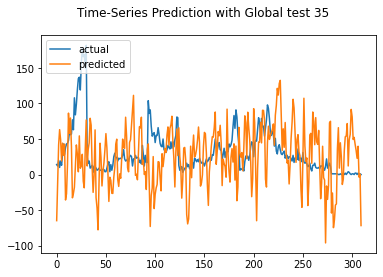

Test MAE: 37.411
Test RMSE: 43.862
Test sMAPE: 93.066
Test R Squared: -0.939
{'mae': 37.411450712142454, 'rmse': 43.861903988141584, 'smape': 93.06603016233086, 'r2': -0.9391432566113822}


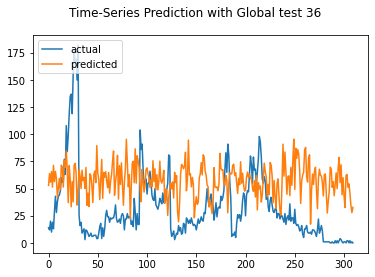

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 36.799
Test RMSE: 44.772
Test sMAPE: 92.322
Test R Squared: -1.020
{'mae': 36.799122463887734, 'rmse': 44.77160998346917, 'smape': 92.32200735430058, 'r2': -1.0204139488781898}


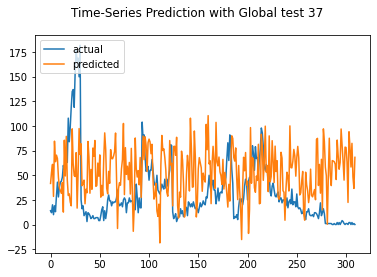

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 32.939
Test RMSE: 44.016
Test sMAPE: 124.078
Test R Squared: -0.953
{'mae': 32.93879015090004, 'rmse': 44.01627852504175, 'smape': 124.07786088800381, 'r2': -0.9528171335987108}


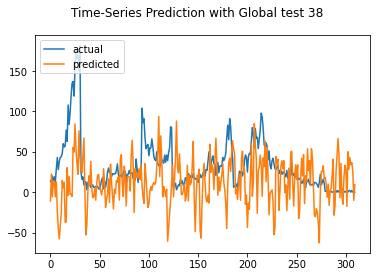

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 44.944
Test RMSE: 55.308
Test sMAPE: 119.553
Test R Squared: -2.083
{'mae': 44.944358591495025, 'rmse': 55.30840844584548, 'smape': 119.5534924709847, 'r2': -2.0833104673442775}


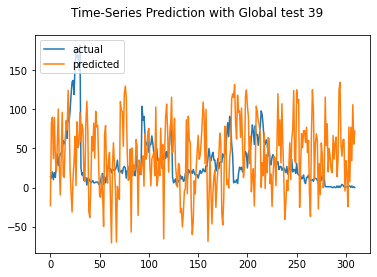

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 39.816
Test RMSE: 52.228
Test sMAPE: 108.942
Test R Squared: -1.749
{'mae': 39.8155284295159, 'rmse': 52.22803428752877, 'smape': 108.94152119559622, 'r2': -1.7494276481032602}


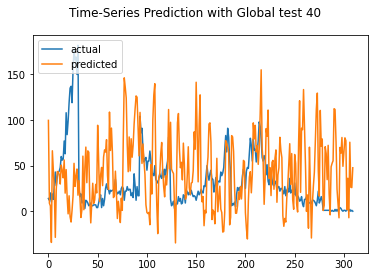

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.720
Test RMSE: 50.491
Test sMAPE: 103.690
Test R Squared: -1.570
{'mae': 41.71992696658258, 'rmse': 50.49133920316945, 'smape': 103.69018347621203, 'r2': -1.5696188776121773}


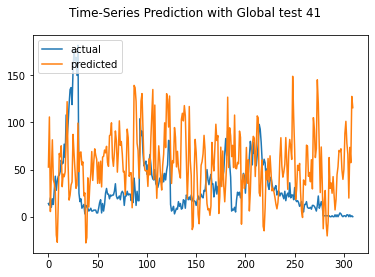

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 36.076
Test RMSE: 47.419
Test sMAPE: 109.725
Test R Squared: -1.266
{'mae': 36.07552457519116, 'rmse': 47.419489693639356, 'smape': 109.72528588816776, 'r2': -1.2664632759633694}


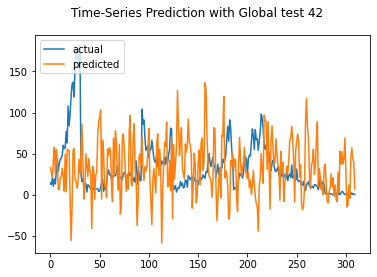

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 38.314
Test RMSE: 46.706
Test sMAPE: 98.920
Test R Squared: -1.199
{'mae': 38.314304167993605, 'rmse': 46.705795958919836, 'smape': 98.91997194551601, 'r2': -1.1987532272964017}


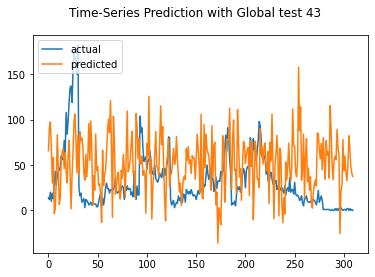

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 39.018
Test RMSE: 46.440
Test sMAPE: 93.992
Test R Squared: -1.174
{'mae': 39.01826492605671, 'rmse': 46.43998508385669, 'smape': 93.99165683612486, 'r2': -1.1737974633899326}


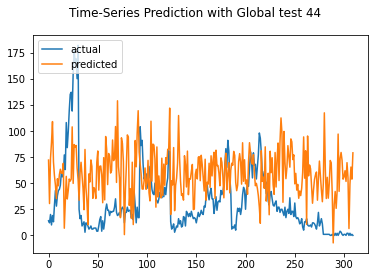

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 37.125
Test RMSE: 44.458
Test sMAPE: 94.327
Test R Squared: -0.992
{'mae': 37.124645327560366, 'rmse': 44.45753209624531, 'smape': 94.32701809594477, 'r2': -0.9921665142241898}


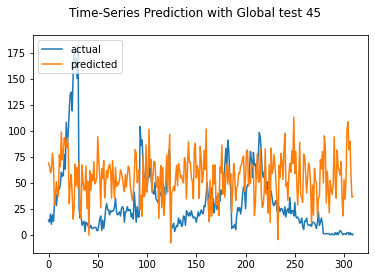

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 38.885
Test RMSE: 51.472
Test sMAPE: 112.087
Test R Squared: -1.670
{'mae': 38.88460041246107, 'rmse': 51.47170595606343, 'smape': 112.08691754150604, 'r2': -1.6703738078051802}


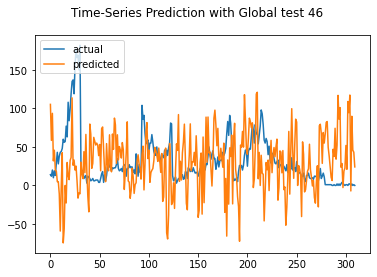

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 34.827
Test RMSE: 42.878
Test sMAPE: 97.941
Test R Squared: -0.853
{'mae': 34.826884154062114, 'rmse': 42.87766343782098, 'smape': 97.94114880606439, 'r2': -0.8530927482633501}


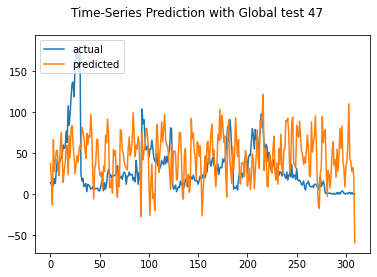

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 35.986
Test RMSE: 44.210
Test sMAPE: 94.813
Test R Squared: -0.970
{'mae': 35.98600243464593, 'rmse': 44.21009051963199, 'smape': 94.81277815019615, 'r2': -0.9700522409080021}


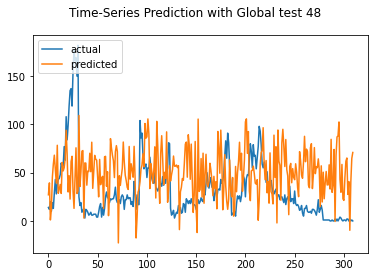

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 33.918
Test RMSE: 44.607
Test sMAPE: 101.382
Test R Squared: -1.006
{'mae': 33.91761105454737, 'rmse': 44.606749764917105, 'smape': 101.38200059288697, 'r2': -1.0055620088783779}


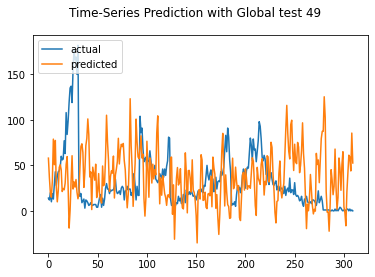

Test MAE: 36.386
Test RMSE: 43.119
Test sMAPE: 91.896
Test R Squared: -0.874
{'mae': 36.38646440505982, 'rmse': 43.119279299281985, 'smape': 91.89630378019515, 'r2': -0.8740359650248155}


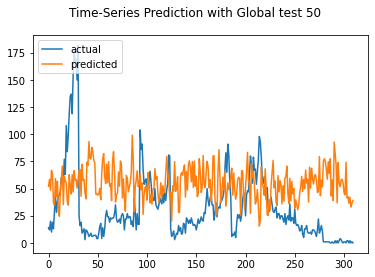

Test MAE: 47.594
Test RMSE: 54.298
Test sMAPE: 102.026
Test R Squared: -1.972
{'mae': 47.59424044086087, 'rmse': 54.29826800865835, 'smape': 102.0255897433736, 'r2': -1.9717131640001115}


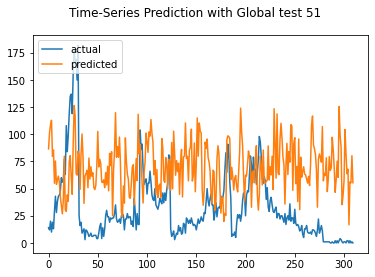

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 39.646
Test RMSE: 48.563
Test sMAPE: 98.383
Test R Squared: -1.377
{'mae': 39.645901909566696, 'rmse': 48.563067991050886, 'smape': 98.38345605393462, 'r2': -1.377098433315251}


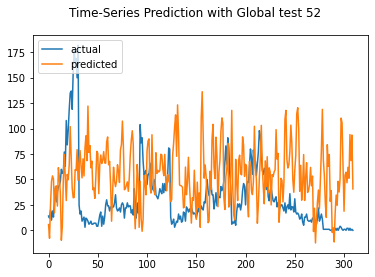

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 41.574
Test RMSE: 51.085
Test sMAPE: 100.636
Test R Squared: -1.630
{'mae': 41.573599750764906, 'rmse': 51.08514131475939, 'smape': 100.63636178047936, 'r2': -1.6304141534389625}


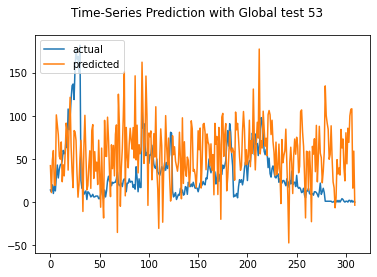

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 39.263
Test RMSE: 47.289
Test sMAPE: 100.257
Test R Squared: -1.254
{'mae': 39.26312499450099, 'rmse': 47.28887627260291, 'smape': 100.25683160013429, 'r2': -1.2539948657327695}


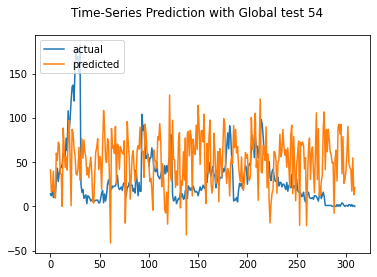

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 35.465
Test RMSE: 45.773
Test sMAPE: 113.596
Test R Squared: -1.112
{'mae': 35.46549029542554, 'rmse': 45.77264520619191, 'smape': 113.5963801118595, 'r2': -1.1117716566017717}


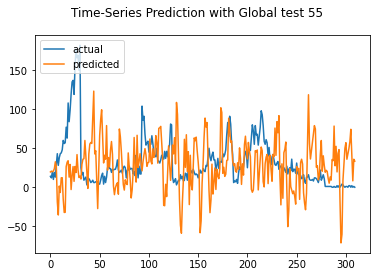

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 38.057
Test RMSE: 45.562
Test sMAPE: 102.891
Test R Squared: -1.092
{'mae': 38.0568102115585, 'rmse': 45.561770158610315, 'smape': 102.890581847251, 'r2': -1.0923585704769607}


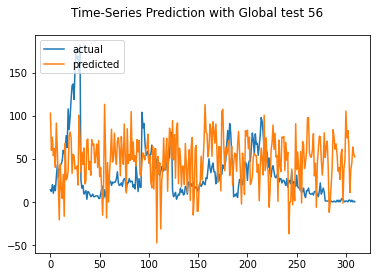

Test MAE: 39.597
Test RMSE: 46.109
Test sMAPE: 96.126
Test R Squared: -1.143
{'mae': 39.596660829359486, 'rmse': 46.108844338256, 'smape': 96.12573220568358, 'r2': -1.1429074222378297}


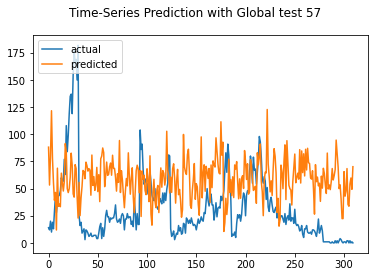

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 40.500
Test RMSE: 47.294
Test sMAPE: 96.341
Test R Squared: -1.254
{'mae': 40.49956686765917, 'rmse': 47.29407144937983, 'smape': 96.34084389302906, 'r2': -1.2544901426745056}


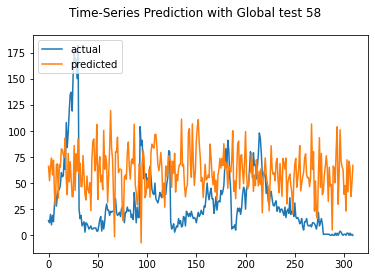

Test MAE: 41.020
Test RMSE: 49.589
Test sMAPE: 95.133
Test R Squared: -1.479
{'mae': 41.01995432146134, 'rmse': 49.58913527437067, 'smape': 95.13250802427132, 'r2': -1.478608900713981}


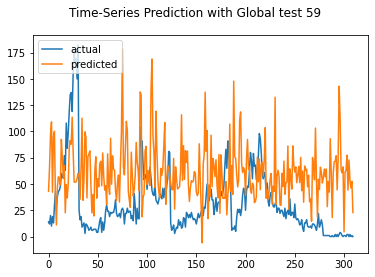

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 34.368
Test RMSE: 46.639
Test sMAPE: 111.175
Test R Squared: -1.192
{'mae': 34.36771935551397, 'rmse': 46.63924771653158, 'smape': 111.17503459173682, 'r2': -1.1924919521702089}


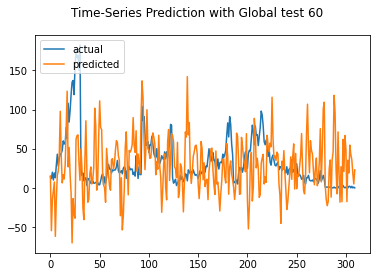

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 42.778
Test RMSE: 54.443
Test sMAPE: 119.045
Test R Squared: -1.988
{'mae': 42.778459449160486, 'rmse': 54.443497355176554, 'smape': 119.04548194190006, 'r2': -1.9876310612476988}


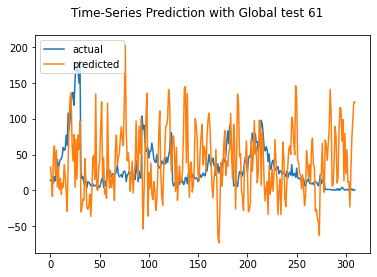

Test MAE: 41.339
Test RMSE: 47.429
Test sMAPE: 96.462
Test R Squared: -1.267
{'mae': 41.338688739653556, 'rmse': 47.428595740153575, 'smape': 96.46224152830688, 'r2': -1.2673338252574409}


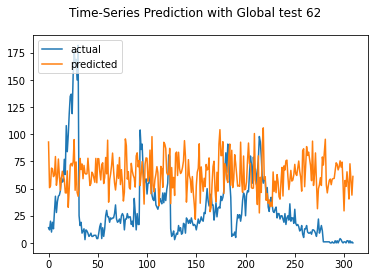

Test MAE: 46.833
Test RMSE: 56.148
Test sMAPE: 101.433
Test R Squared: -2.178
{'mae': 46.832547773084336, 'rmse': 56.14760118284764, 'smape': 101.43288207041051, 'r2': -2.1775862488660036}


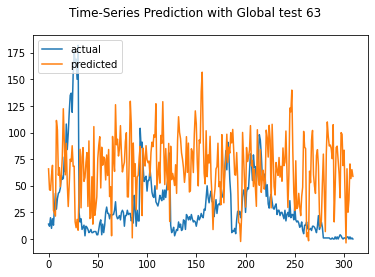

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 36.087
Test RMSE: 43.749
Test sMAPE: 90.591
Test R Squared: -0.929
{'mae': 36.08745602330854, 'rmse': 43.74902710709488, 'smape': 90.59130535508676, 'r2': -0.9291754814995099}


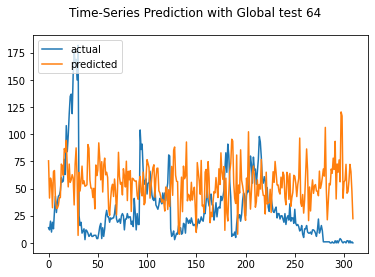

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 37.164
Test RMSE: 45.331
Test sMAPE: 117.196
Test R Squared: -1.071
{'mae': 37.1637844387562, 'rmse': 45.33123405794633, 'smape': 117.19581029660762, 'r2': -1.0712380636511831}


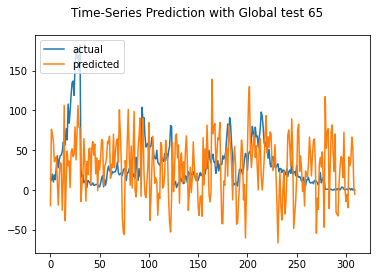

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 35.730
Test RMSE: 43.278
Test sMAPE: 92.191
Test R Squared: -0.888
{'mae': 35.73037406417632, 'rmse': 43.27831208808549, 'smape': 92.19107946034086, 'r2': -0.88788511902543}


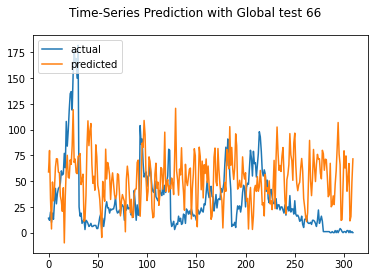

Test MAE: 38.229
Test RMSE: 43.852
Test sMAPE: 94.875
Test R Squared: -0.938
{'mae': 38.22905297971541, 'rmse': 43.85213013306507, 'smape': 94.87473251124428, 'r2': -0.9382791448524948}


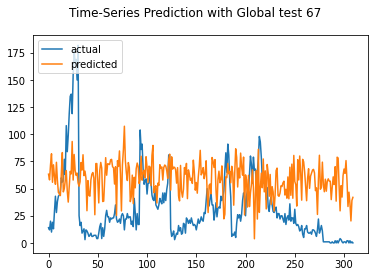

Test MAE: 44.794
Test RMSE: 53.711
Test sMAPE: 105.934
Test R Squared: -1.908
{'mae': 44.79404393242252, 'rmse': 53.711109612624725, 'smape': 105.93443184454344, 'r2': -1.9077909699058124}


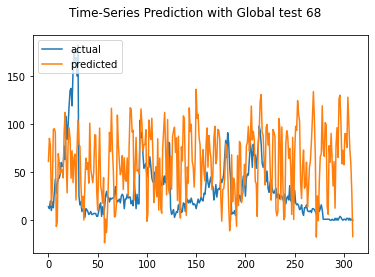

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 40.169
Test RMSE: 51.061
Test sMAPE: 118.906
Test R Squared: -1.628
{'mae': 40.16929114124467, 'rmse': 51.0614919328085, 'smape': 118.90646040861158, 'r2': -1.627979266574496}


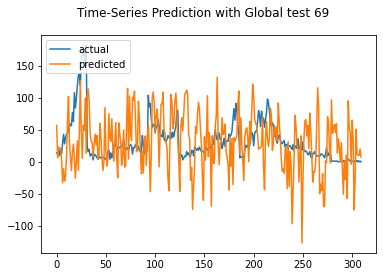

Test MAE: 30.239
Test RMSE: 41.194
Test sMAPE: 96.284
Test R Squared: -0.710
{'mae': 30.23884267941598, 'rmse': 41.19432984802984, 'smape': 96.28352384201388, 'r2': -0.7104477761645027}


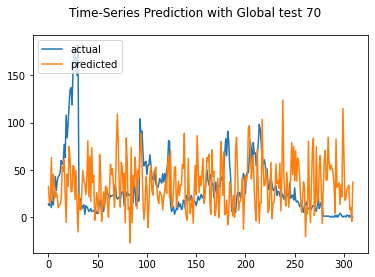

Test MAE: 46.811
Test RMSE: 54.791
Test sMAPE: 100.946
Test R Squared: -2.026
{'mae': 46.81112639519476, 'rmse': 54.791214246268375, 'smape': 100.94563712803256, 'r2': -2.025915421026217}


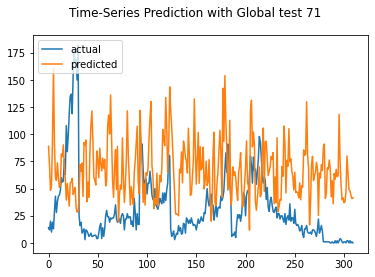

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 38.096
Test RMSE: 44.726
Test sMAPE: 95.054
Test R Squared: -1.016
{'mae': 38.0964915352483, 'rmse': 44.72596451185813, 'smape': 95.05369647894969, 'r2': -1.0162963513115666}


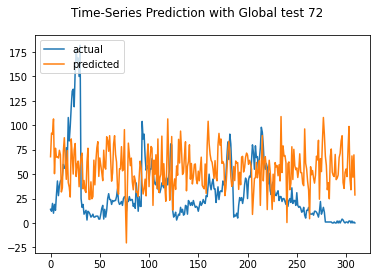

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 37.789
Test RMSE: 46.191
Test sMAPE: 95.774
Test R Squared: -1.151
{'mae': 37.78912005549477, 'rmse': 46.19139334211846, 'smape': 95.77448506953532, 'r2': -1.1505872165902487}


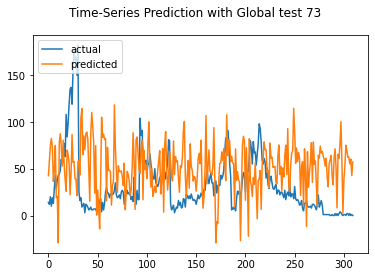

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 40.147
Test RMSE: 49.053
Test sMAPE: 98.317
Test R Squared: -1.425
{'mae': 40.147112458559775, 'rmse': 49.0529413441252, 'smape': 98.31674052234058, 'r2': -1.4252976299984454}


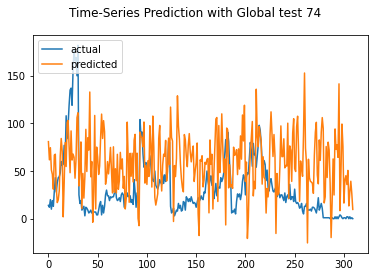

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 34.819
Test RMSE: 44.846
Test sMAPE: 108.800
Test R Squared: -1.027
{'mae': 34.81922029862481, 'rmse': 44.84585030589382, 'smape': 108.79975285014612, 'r2': -1.0271200085866359}


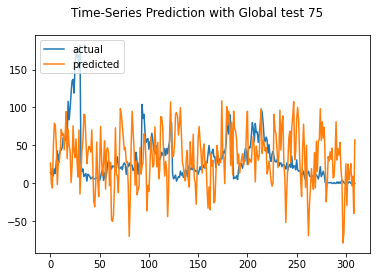

Test MAE: 42.052
Test RMSE: 49.012
Test sMAPE: 97.443
Test R Squared: -1.421
{'mae': 42.05222598198922, 'rmse': 49.01229055890889, 'smape': 97.44328067011901, 'r2': -1.4212795467253447}


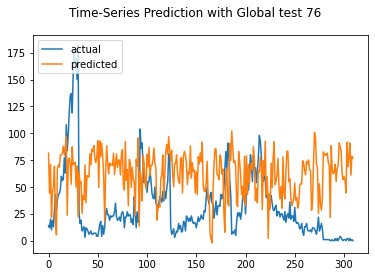

Test MAE: 45.473
Test RMSE: 53.337
Test sMAPE: 100.414
Test R Squared: -1.867
{'mae': 45.47290260291869, 'rmse': 53.336524778384955, 'smape': 100.41432158647612, 'r2': -1.8673741444247303}


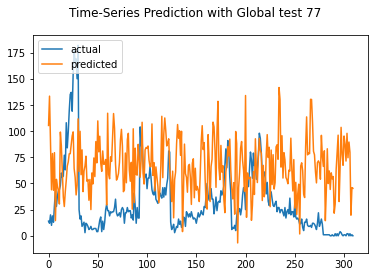

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 39.928
Test RMSE: 48.857
Test sMAPE: 98.714
Test R Squared: -1.406
{'mae': 39.92821250596354, 'rmse': 48.85671552456568, 'smape': 98.71396449796411, 'r2': -1.405932669533223}


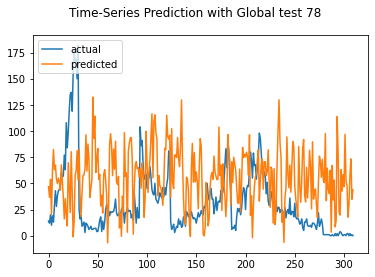

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 38.049
Test RMSE: 46.626
Test sMAPE: 92.571
Test R Squared: -1.191
{'mae': 38.04881423875209, 'rmse': 46.62613683163233, 'smape': 92.57146516076595, 'r2': -1.1912594507611725}


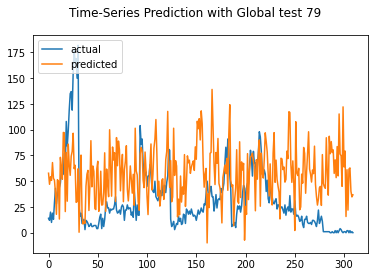

Test MAE: 49.115
Test RMSE: 57.882
Test sMAPE: 104.392
Test R Squared: -2.377
{'mae': 49.11467311843749, 'rmse': 57.88214618510155, 'smape': 104.39235883700822, 'r2': -2.3769465443173488}


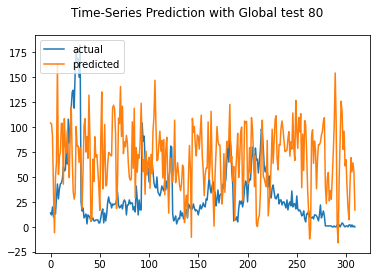

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 37.786
Test RMSE: 45.719
Test sMAPE: 94.409
Test R Squared: -1.107
{'mae': 37.78557972677292, 'rmse': 45.71916211028631, 'smape': 94.40907691238958, 'r2': -1.106839536086838}


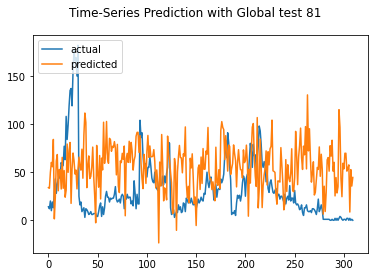

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 36.060
Test RMSE: 45.062
Test sMAPE: 107.930
Test R Squared: -1.047
{'mae': 36.06031769408334, 'rmse': 45.061502842297884, 'smape': 107.93039408618718, 'r2': -1.046662715429675}


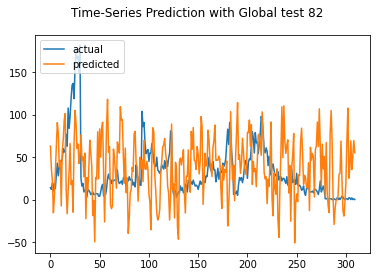

Test MAE: 41.859
Test RMSE: 48.460
Test sMAPE: 98.152
Test R Squared: -1.367
{'mae': 41.8593141371204, 'rmse': 48.46014360250584, 'smape': 98.15214857652224, 'r2': -1.367033083425715}


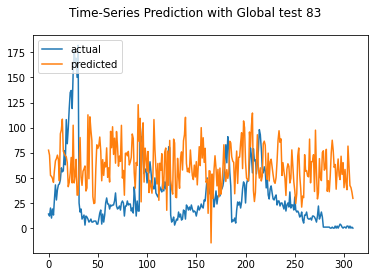

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 41.699
Test RMSE: 50.242
Test sMAPE: 97.043
Test R Squared: -1.544
{'mae': 41.69919547727031, 'rmse': 50.24155958633159, 'smape': 97.04258647389806, 'r2': -1.5442580593790471}


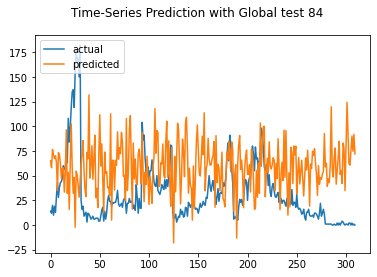

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 44.794
Test RMSE: 54.589
Test sMAPE: 105.966
Test R Squared: -2.004
{'mae': 44.79364657498175, 'rmse': 54.589490768346515, 'smape': 105.9659588226742, 'r2': -2.0036755584149146}


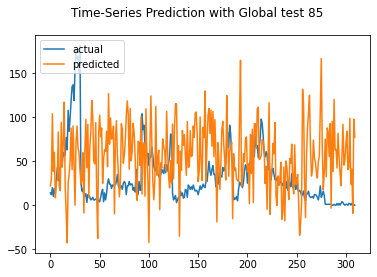

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 37.447
Test RMSE: 47.668
Test sMAPE: 112.858
Test R Squared: -1.290
{'mae': 37.44722244037736, 'rmse': 47.66771862021002, 'smape': 112.85758197786528, 'r2': -1.2902540964900284}


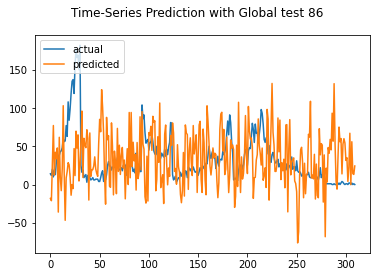

Test MAE: 34.612
Test RMSE: 41.640
Test sMAPE: 89.998
Test R Squared: -0.748
{'mae': 34.61185261818671, 'rmse': 41.64013488186639, 'smape': 89.99827873495137, 'r2': -0.747669027775858}


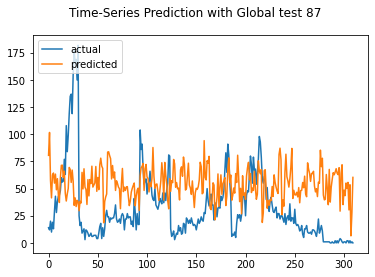

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 30.212
Test RMSE: 40.994
Test sMAPE: 108.692
Test R Squared: -0.694
{'mae': 30.21212788128084, 'rmse': 40.99382113280065, 'smape': 108.69234934430457, 'r2': -0.6938374791311446}


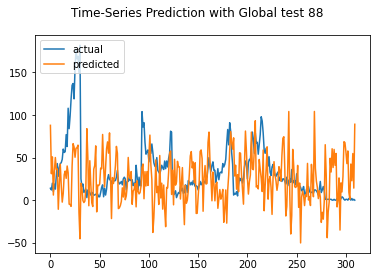

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 37.869
Test RMSE: 45.428
Test sMAPE: 94.575
Test R Squared: -1.080
{'mae': 37.86857792485145, 'rmse': 45.42842280236176, 'smape': 94.5749815796884, 'r2': -1.0801289232328495}


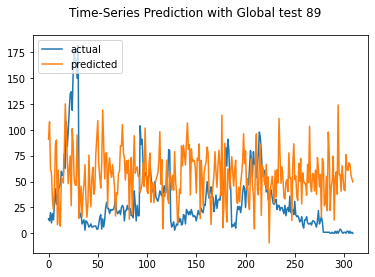

Test MAE: 39.995
Test RMSE: 46.018
Test sMAPE: 95.489
Test R Squared: -1.134
{'mae': 39.99530371389081, 'rmse': 46.018077442382896, 'smape': 95.48895148902365, 'r2': -1.134478947718537}


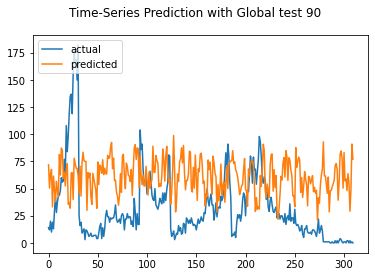

Test MAE: 35.536
Test RMSE: 46.775
Test sMAPE: 99.252
Test R Squared: -1.205
{'mae': 35.53629098361538, 'rmse': 46.774531735435716, 'smape': 99.2520638951116, 'r2': -1.2052296920141354}


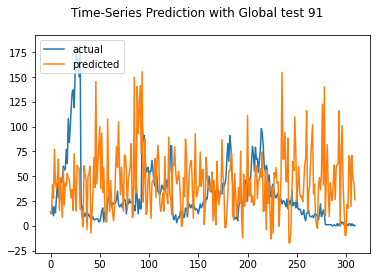

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 39.894
Test RMSE: 48.692
Test sMAPE: 100.054
Test R Squared: -1.390
{'mae': 39.894085702588484, 'rmse': 48.69189811738583, 'smape': 100.05370937482171, 'r2': -1.389727293466497}


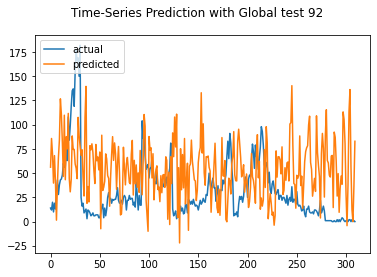

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 37.578
Test RMSE: 46.089
Test sMAPE: 94.376
Test R Squared: -1.141
{'mae': 37.5780107932706, 'rmse': 46.08935728827258, 'smape': 94.3764603520592, 'r2': -1.1410964846477158}


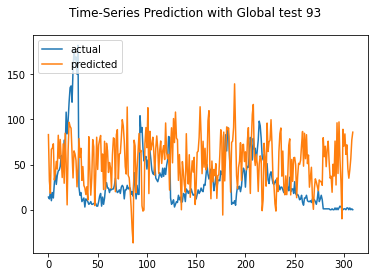

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 39.621
Test RMSE: 46.805
Test sMAPE: 97.951
Test R Squared: -1.208
{'mae': 39.62090694519781, 'rmse': 46.8048542689503, 'smape': 97.95087814811221, 'r2': -1.2080897880140529}


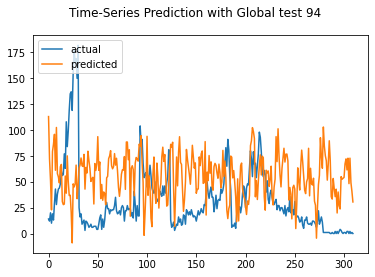

Test MAE: 37.186
Test RMSE: 44.429
Test sMAPE: 92.508
Test R Squared: -0.990
{'mae': 37.18559412187145, 'rmse': 44.42930171382608, 'smape': 92.5084203548555, 'r2': -0.9896372795184654}


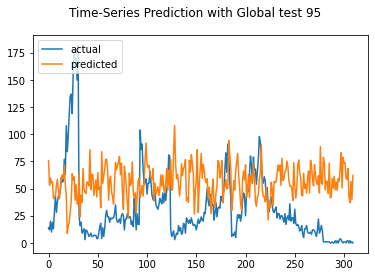

Test MAE: 34.994
Test RMSE: 45.319
Test sMAPE: 89.718
Test R Squared: -1.070
{'mae': 34.99352896328895, 'rmse': 45.3194162302084, 'smape': 89.71796250149738, 'r2': -1.0701582631776598}


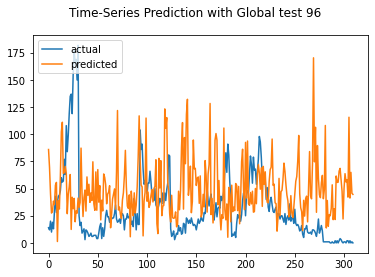

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 36.031
Test RMSE: 44.952
Test sMAPE: 93.870
Test R Squared: -1.037
{'mae': 36.03070643217333, 'rmse': 44.95201802006195, 'smape': 93.86962134216796, 'r2': -1.0367293456815854}


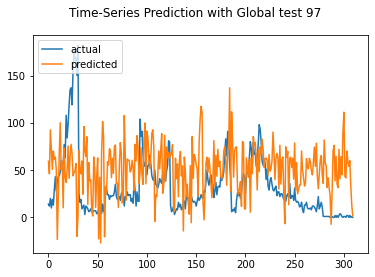

Test MAE: 46.548
Test RMSE: 52.056
Test sMAPE: 102.198
Test R Squared: -1.731
{'mae': 46.54803270216911, 'rmse': 52.056218107764295, 'smape': 102.19755430397275, 'r2': -1.7313676489725807}


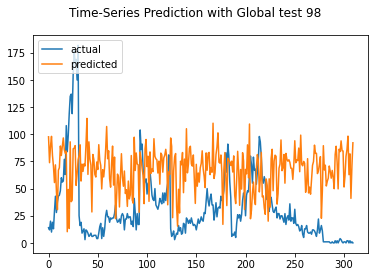

Test MAE: 45.706
Test RMSE: 51.751
Test sMAPE: 102.067
Test R Squared: -1.699
{'mae': 45.70582724617373, 'rmse': 51.751244350156064, 'smape': 102.06712779055786, 'r2': -1.6994577095133963}


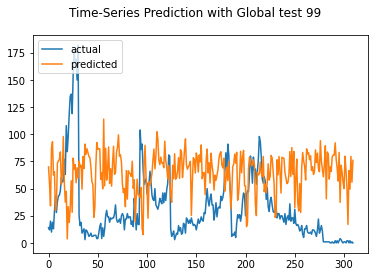

rmse : average=48.687, std=6.425
mae : average=39.742, std=5.753
smape : average=101.970, std=9.443
r2 : average=-1.431, std=0.747


([48.68676375196225, 6.42533544918141],
 [39.74181394578661, 5.753027588462172],
 [101.97017802456229, 9.443127065382464],
 [-1.430836108076876, 0.7471789552296432])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')